Traditional approach (unscalable)

In [29]:
# reading names file
words = open('names.txt', 'r').read().splitlines()

In [30]:
# creating char to index and index to char dictionaries
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [31]:
import torch

# counting occurrences of each two letter pair (including starting and ending characters) in the list of names 
count = torch.zeros((27,27), dtype=torch.int32)

for word in words:
	chars = ['.'] + list(word) + ['.']
	for c1, c2 in zip(chars, chars[1:]):
		ix1 = stoi[c1]
		ix2 = stoi[c2]
		count[ix1, ix2] += 1

In [32]:
count.shape

torch.Size([27, 27])

(-0.5, 26.5, 26.5, -0.5)

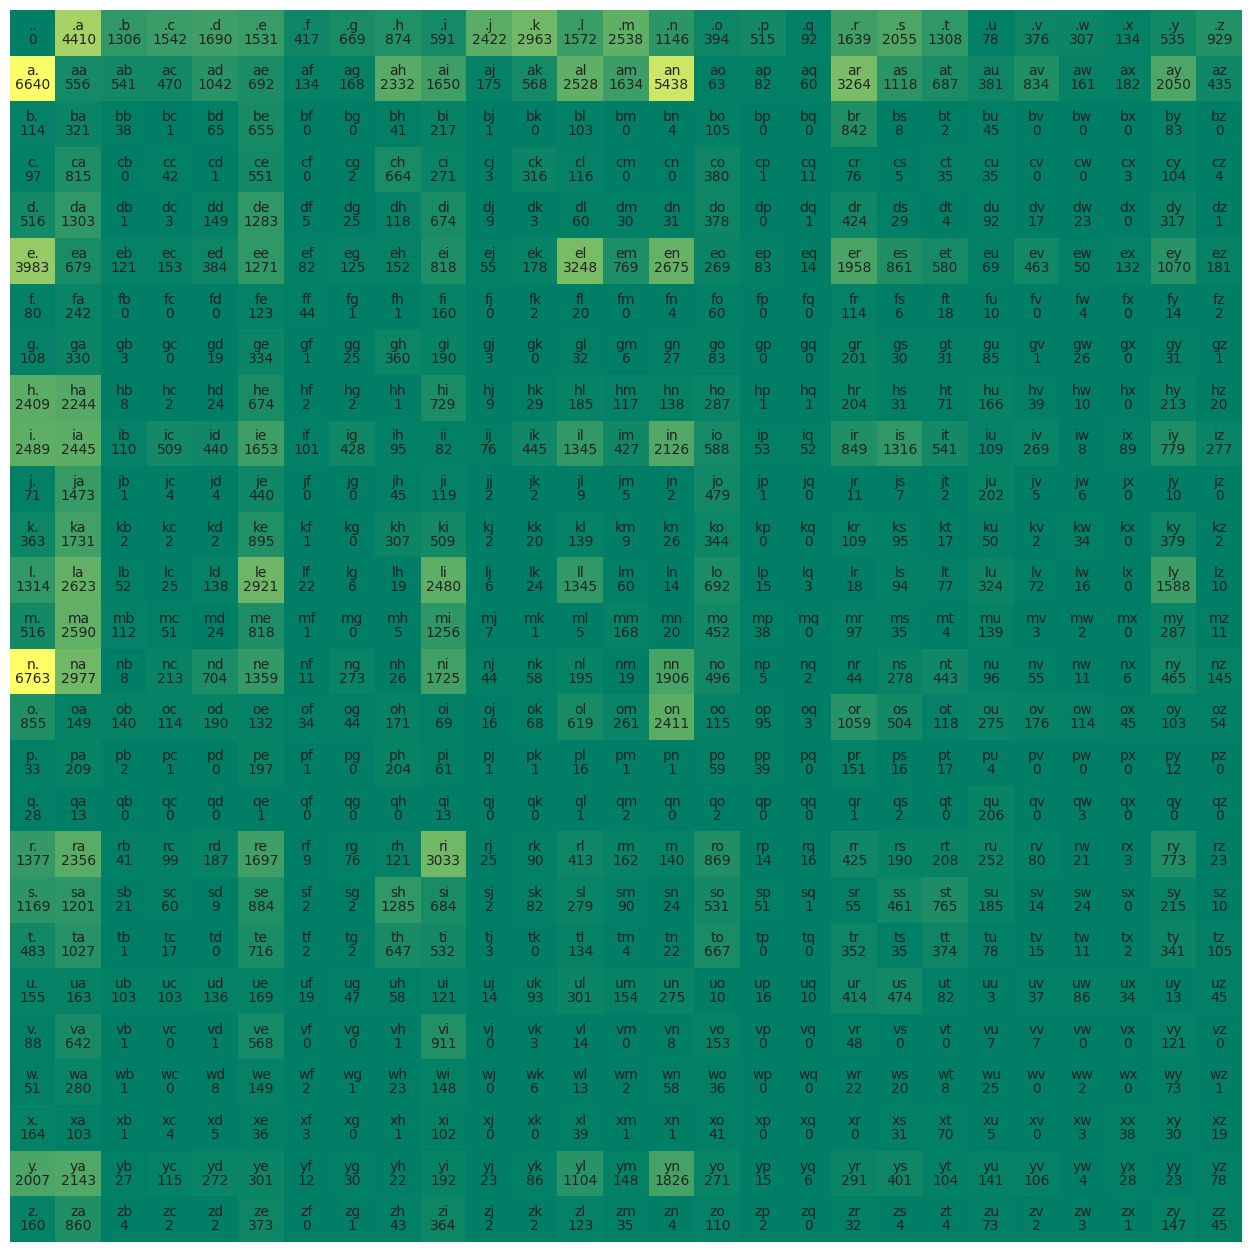

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

# visualize the count matrix
# first column is the starting character, first row is the ending character
plt.figure(figsize=(16,16))
plt.imshow(count, cmap='summer')
for i in range(27):
	for j in range(27):
		ch_str = itos[i] + itos[j]
		plt.text(j, i, ch_str, ha='center', va='bottom', color='#222222')
		plt.text(j, i, count[i, j].item(), ha='center', va='top', color='#222222')

plt.axis('off')

In [34]:
# normalizing the first column
g = torch.Generator().manual_seed(2147483647)
p = count[0].float()
p = p / p.sum()
p.sum()

tensor(1.)

In [35]:
# sampling example of one char
g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itos[ix]

'j'

In [36]:
# normalizing all rows to generate a probability distribution
probs_old = (count+1).float()
probs_old /= probs_old.sum(dim=1, keepdim=True)

In [37]:
# sampling names from the distribution using torch.multinomial
# pick characters until a '.' is encountered
g = torch.Generator().manual_seed(2147483647)
for i in range(10):
	ix = 0
	new_name = ''
	while True:
		p = probs_old[ix].float()
		ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
		new_name += itos[ix]
		if ix == 0:
			break
	print(new_name)	

junide.
janasah.
p.
cony.
a.
nn.
kohin.
tolian.
juee.
ksahnaauranilevias.


In [38]:
log_likelihood = 0.0
n = 0
# for word in ['andrejq']:
for word in words[:]:
	chars = ['.'] + list(word) + ['.']
	for c1, c2 in zip(chars, chars[1:]):
		ix1 = stoi[c1]
		ix2 = stoi[c2]
		prob = probs_old[ix1,ix2]
		logprob = torch.log(prob)
		log_likelihood += logprob
		n += 1
		print(f'{c1}{c2}: {prob:.4f} {logprob:.4f}')

print(f'{log_likelihood=}')
neg_log_likelihood = -log_likelihood
print(f'{neg_log_likelihood=}')
print(f'{neg_log_likelihood/n}') # loss function: average negative log likelihood

.e: 0.0478 -3.0410
em: 0.0377 -3.2793
mm: 0.0253 -3.6753
ma: 0.3885 -0.9454
a.: 0.1958 -1.6305
.o: 0.0123 -4.3965
ol: 0.0779 -2.5526
li: 0.1774 -1.7293
iv: 0.0152 -4.1845
vi: 0.3508 -1.0476
ia: 0.1380 -1.9807
a.: 0.1958 -1.6305
.a: 0.1376 -1.9835
av: 0.0246 -3.7041
va: 0.2473 -1.3971
a.: 0.1958 -1.6305
.i: 0.0185 -3.9919
is: 0.0743 -2.5998
sa: 0.1478 -1.9119
ab: 0.0160 -4.1363
be: 0.2455 -1.4044
el: 0.1589 -1.8396
ll: 0.0962 -2.3408
la: 0.1876 -1.6733
a.: 0.1958 -1.6305
.s: 0.0641 -2.7468
so: 0.0654 -2.7270
op: 0.0121 -4.4180
ph: 0.1947 -1.6364
hi: 0.0955 -2.3485
ia: 0.1380 -1.9807
a.: 0.1958 -1.6305
.c: 0.0481 -3.0339
ch: 0.1869 -1.6774
ha: 0.2937 -1.2251
ar: 0.0963 -2.3405
rl: 0.0325 -3.4256
lo: 0.0496 -3.0047
ot: 0.0149 -4.2032
tt: 0.0670 -2.7031
te: 0.1281 -2.0549
e.: 0.1948 -1.6357
.m: 0.0792 -2.5358
mi: 0.1885 -1.6687
ia: 0.1380 -1.9807
a.: 0.1958 -1.6305
.a: 0.1376 -1.9835
am: 0.0482 -3.0321
me: 0.1228 -2.0971
el: 0.1589 -1.8396
li: 0.1774 -1.7293
ia: 0.1380 -1.9807
a.: 0.1958 -

Linear NN approach (scalable to more than two-character bigrams)

In [39]:
# training set of bigrams
ins, outs = [], []

for word in words:
	chars = ['.'] + list(word) + ['.']
	for c1, c2 in zip(chars, chars[1:]):
		ix1 = stoi[c1]
		ix2 = stoi[c2]
		ins.append(ix1)
		outs.append(ix2)

ins = torch.tensor(ins)
outs = torch.tensor(outs)

print(ins.shape)
print(outs.shape)

torch.Size([228146])
torch.Size([228146])


In [40]:
import torch.nn.functional as F
in_enc = F.one_hot(ins, num_classes=27).float()
W = torch.randn((27,27), requires_grad=True)
(in_enc @ W)[3,13]

tensor(-1.7111, grad_fn=<SelectBackward0>)

In [41]:
(in_enc[3] * W[:,13]).sum()

tensor(-1.7111, grad_fn=<SumBackward0>)

In [42]:
# visualization on most likely next character by the nn
# plt.figure(figsize=(16,16))
# for i in range(probs.shape[0]):
# 	for j in range(27):
# 		plt.text(j, i, itos[j], ha='center', va='center', color='black')
# plt.imshow(probs, cmap='summer')

In [43]:
loss_arr = []
for i in range(100):
	# forward pass
	logits = (in_enc @ W) # log counts
	counts = logits.exp() # undo log counts with exponentiation, equivalent to count matrix
	probs = counts / counts.sum(1, keepdim=True) # normalize counts / softmax
	loss = -probs[torch.arange(ins.nelement()), outs].log().mean() # neg-avg-log-likelihood
	loss += 0.1 * (W**2).mean()
	loss_arr.append(loss)
	# print(f'{loss.item():.4f}')
	# backward pass
	W.grad = None
	loss.backward()
	W.data += -10 * W.grad

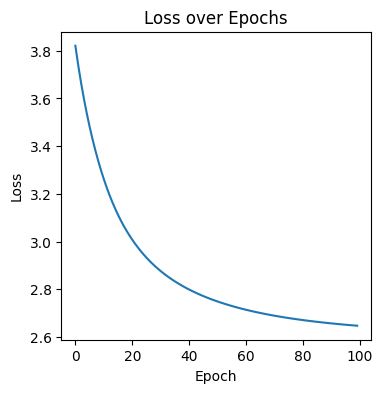

In [44]:
import numpy as np

plt.figure(figsize=(4,4))
epochs = len(loss_arr)
plt.plot(range(epochs), torch.tensor(loss_arr).detach().numpy())
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.show()

In [45]:
# sampling from NN
g = torch.Generator().manual_seed(2147483647)
for i in range(10):
	ix = 0
	new_name = ''
	while True:
		#old probs from trad approach
		# p = probs_old[ix].float()

		# new probs from linear NN
		in_enc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
		logits = in_enc @ W
		counts = logits.exp()
		p = counts / counts.sum(1, keepdim=True)

		ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
		new_name += itos[ix]
		if ix == 0:
			break
	print(new_name)	

junide.
janaqah.
pxlfay.
a.
nn.
koi.
ritolian.
jgha.
ksahnaauvanilevias.
dbdainrwieta.
